In [ ]:
#Install Numba, Scipy, Trackpy, ipyparallel & pims before you run this code

In [17]:
"""
Created on Sun Mar 29 15:40:11 2020 @author: Talha
Most of this code comes from "walkthrough" tutorial on Tracky website: http://soft-matter.github.io/trackpy/v0.4.2/tutorial/walkthrough.html
and ideas on stepsize implementation from Han Yang's code
"""
#Use Jupyter notebooks to make use of your multi-core processors; before importing trackpy to allow multi-core processing use the magic command: %%px
#Don't forget to turn on the "IPython Clusters" in Jupyter to enjoy better speeds using parallel computing

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
#%env PYTHONHASHSEED=0#important command to get reproducible results of D from cut traj using trackpy 5.0, but slows down code

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import csv
import scipy as sp
from scipy import signal
from itertools import chain

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='red')

from ipyparallel import Client
client = Client()
view = client.load_balanced_view()
import trackpy as tp
tp.quiet()

In [18]:
%%px
import trackpy as tp

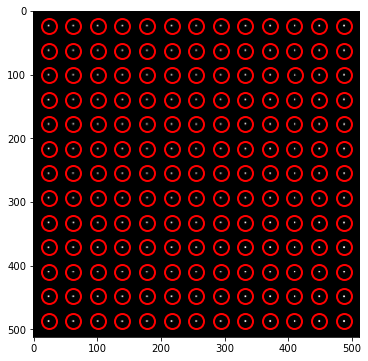

"\nfig, ax = plt.subplots()\nax.hist(f['mass'], bins=20)\nax.set(xlabel='mass', ylabel='count');\n#shows bias\nplt.figure()\ntp.subpx_bias(tp.locate(frames[:], 9, minmass=1000));\n"

In [19]:
#save your movie as tiff using Imagej before opening it here!
path = 'trackpy_testing/0p8_2k_trackpy2'
name = '0p8_2k_trackpy2'
frames = pims.TiffStack(path + '.tif', as_grey=True)#opens the tiffstack of movie frames
frames#gives you info about pixels and frames

# make a preview figure of a frame's particles detected
f = tp.locate(frames[0], 7, minmass=80) #adjust minmass if all the molecules are not correctly located
plt.figure()  
tp.annotate(f, frames[0]);
'''
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count');
#shows bias
plt.figure()
tp.subpx_bias(tp.locate(frames[:], 9, minmass=1000));
'''

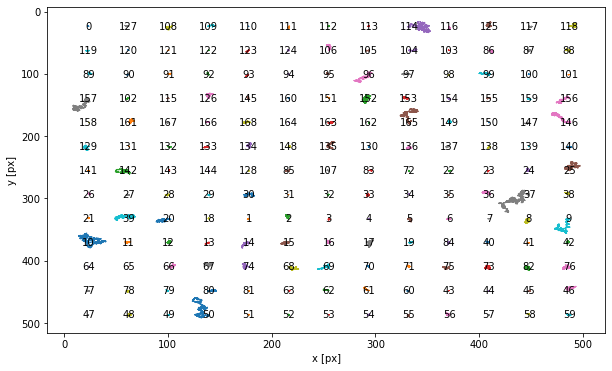

Before: 169 After: 169


In [20]:
frames_preload = list(frames[:])#load all frames

# tp.batch, which calls tp.locate on each frame and collects the results
#f = tp.batch(frames_preload[:1998], 7, minmass=29000, max_iterations=1, characterize=False, processes="auto");
f = tp.batch(frames_preload[:1998], 7, minmass=10, characterize=False, processes="auto");#radius is always an odd number

#implementats Crocker-Grier linking algorithmto link trajectories, needs to specify a maximum displacement between adjacent frames
#Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance
t = tp.link_df(f, 10, memory=5)
plt.figure()
tp.plot_traj(t, label=True, superimpose=None);

# Compare the number of particles in the unfiltered and filtered data 
# that last for a given number of frames.
t1 = tp.filter_stubs(t, (len(frames_preload)-5))
print('Before:', t['particle'].nunique(),'After:', t1['particle'].nunique())

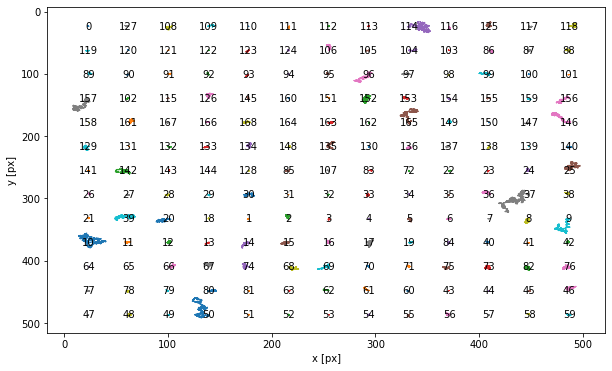

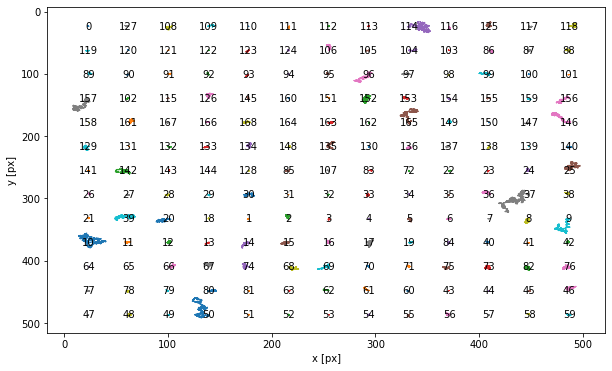

Before: 169 After: 169


In [13]:
#if you want to play with the impact of displavement and memory and future improve tracking
t = tp.link_df(f, 5, memory=35)
plt.figure()
tp.plot_traj(t, label=True, superimpose=None);

# Compare the number of particles in the unfiltered and filtered data 
# that last for a given number of frames.
t1 = tp.filter_stubs(t, 900)
tp.plot_traj(t1, label=True, superimpose=None);
print('Before:', t['particle'].nunique(),'After:', t1['particle'].nunique())

In [ ]:
'''
#Compute xy drift and remove drift
drft = tp.compute_drift(t1)
tm = tp.subtract_drift(t1.copy(), drft)
plt.figure()
ax = tp.plot_traj(tm)

#If you would like to use HD5 format:

#PandasHDFStore -- fastest for a small (~100) number of frames
#PandasHDFStoreBig -- fastest for a medium or large number of frames
#PandasHDFStoreSingleNode -- optimizes HDF queries that access multiple frames (advanced)
with tp.PandasHDFStoreSingleNode('data.h5') as s:
    tp.batch(frames_preload[:1998], 7, minmass=60, characterize=False, processes="auto", output=s)
    all_results = s.dump()    
with tp.PandasHDFStore('data.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 4 frames
    for linked in tp.link_df_iter(s, 2, memory=2):
        s.put(linked)
    # get results by frame with s.get(frame_number) or, when you have sufficient memory, retrieve them all
    trajectories = pd.concat(iter(s))
trajectories.head()
'''
'''
#adaptive search; refer to tutorial on Adaptive Search on trackpy website
tracks_adaptive = tp.link_df(f, 0.95, adaptive_stop=0.56, adaptive_step=0.99)
tracks_adaptive.groupby('particle').particle.count().value_counts()
plt.figure()
ax = tp.plot_traj(tracks_adaptive)'''

In [21]:
#Stepsize Calculation by frame:
i=0
j=1
stepsize_list = []
for i in range(len(frames_preload)-2):
    mtn = tp.motion.relate_frames(t1, i, j)#Find the displacement vector of all particles between two frames
    step = np.sqrt((mtn.dx**2) + (mtn.dy**2))*254
    #print(mtn)
    #print(step)
    i = i+1
    j = j+1
    stepsize_list.append(step[:].tolist())
steps = list(chain.from_iterable(stepsize_list))#make the combined list of stepsizes from all the frames
med_step = np.nanmedian(steps)##calculates the median step size
print(r'The median stepsize is {0:.3f} nm'.format(med_step))

#saves step sizes in a text file
with open(('step' + name + '.txt'), 'w') as f:
    for s in steps:
        f.write("%s\n" % s)

The median stepsize is 9.824 nm


C:\Users\Keewook\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Keewook\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


[1.75355417e-01 1.90983779e-01 1.92195034e-01 2.90684626e-01
 3.61969638e-01 3.63987227e-01 3.93562281e-01 4.06777537e-01
 4.22794411e-01 4.81232840e-01 5.71194126e-01 6.31925918e-01
 7.32757027e-01 7.72692196e-01 8.55652533e-01 9.75549792e-01
 1.08017364e+00 1.10425224e+00 1.10499290e+00 1.11382625e+00
 1.17696214e+00 1.27955106e+00 1.28131990e+00 1.32303282e+00
 1.36990187e+00 1.51463451e+00 1.52820315e+00 1.56178195e+00
 1.71644580e+00 1.75955534e+00 1.86843921e+00 1.96639347e+00
 1.97838489e+00 2.10843502e+00 2.11564023e+00 2.15510026e+00
 2.26608608e+00 2.34190847e+00 2.63856575e+00 2.76256323e+00
 2.82777119e+00 2.95225541e+00 3.02273758e+00 3.06985970e+00
 3.19073654e+00 3.26431265e+00 3.32953105e+00 3.38400459e+00
 3.39227150e+00 3.68310762e+00 3.98473795e+00 4.32177548e+00
 4.47500488e+00 4.49481701e+00 5.06983821e+00 5.10737266e+00
 5.13413040e+00 5.26352447e+00 5.29994866e+00 5.71090230e+00
 5.86498564e+00 5.94847496e+00 6.05446608e+00 6.05534151e+00
 6.09896457e+00 6.201975

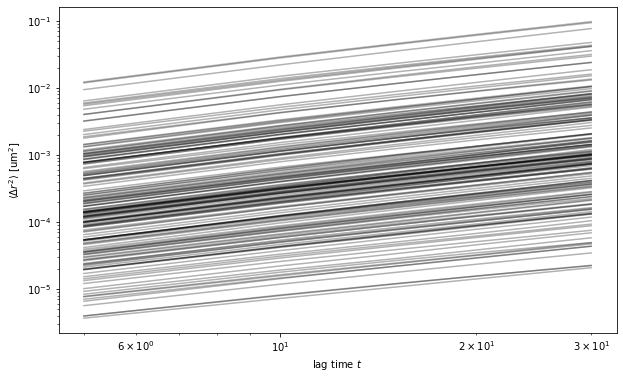

In [22]:
#Compute the mean squared displacement for every molecule
im = tp.imsd(t1, 0.254, 0.2, max_lagtime=6)  # microns per pixel = 0.254, frames per second = 0.2, D calculated from first 6 pts
slope = np.linalg.lstsq(im.index[:, np.newaxis], im)[0][0]

#plot MSDs
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [um$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set(xlim=(0, 16), ylim=(0, 20))

#calculates D for every molecule
D = (slope/4)*(10**6)
#print(D)
D.sort() 
print(D)
med = np.median(D)#calculates the median D
print(r'The median diffusion coefficient is {0:.3f} nm²/s'.format(med))

#saves Diffusion coefficients in a csv file
np.savetxt(name +'D.csv', D, delimiter=',', comments="")